In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#read data
ts_data = pd.read_csv('./data/1-retail_daily_amount.csv', index_col='Date', parse_dates=True)
log_data = pd.read_csv('./data/2-retail_daily_amount_log.csv', index_col='Date', parse_dates=True)
log_data_r_mean = pd.read_csv('./data/2-retail_daily_amount_log_r_mean.csv', index_col='Date', parse_dates=True)
log_returns = pd.read_csv('./data/2-retail_daily_amount_log_returns.csv', index_col='Date', parse_dates=True)
df_diff = pd.read_csv('./data/2-retail_daily_amount_diff.csv', index_col='Date', parse_dates=True)

### LSTM Model

Long Short Term Memory networks makes the learning happens with memory, by using a looping back node

This node has 4 gates that keep tracking of previous learned values:
- Input Gate
- Forget Gate
- Output Gate
- Gate

We will work with Keras API that simplifies the work with Tensorflow (open source library)

In [3]:
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [4]:
# fix seed to make sure it is reproducible
np.random.seed(123)

The function below is the responsable to create a matrix that will link the current values with its X precessor (look at past).
It means that depending on how much we to go back, the link will keep a longer memory.

In [5]:
def build_matrix(data, return_iter):
    dataX, dataY = [], []
    for i in range(return_iter, len(data)):
        dataX.append(data[i-return_iter:i,0])
        dataY.append(data[i, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
#This function will allow us to test the LSTM in different scenarios
def run_univariate_LSTM(data, return_iter, split_train_test, is_log: bool, epochs):
    #Convert to numpy array
    values = data.values
    
    # Scale data, as it is needed for the LSTM
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(values)
    
    train_len = math.ceil(len(scaled_data) * split_train_test)
    test_len = len(scaled_data) - train_len

    train = scaled_data[0:train_len,:]
    test  = scaled_data[train_len-return_iter:,:]
    
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    x_test = []
    y_test = []

    x_train, y_train = build_matrix(train, return_iter)
    x_test, y_test = build_matrix(test, return_iter)
    
    # Reshape the data to fit LSTM model requirement.
    x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

    # Build the LSTM model
    # We will work with a model with 50 cells, a intermediary layer with 25 cells
    # and finally 1 output
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    # Compile the model. We will use the adam implementation and the mean square error as
    # the loss metric
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model.
    model.fit(x_train, y_train, batch_size = 1, epochs = epochs)
    
    # Get the models predicted price values.
    predictions = model.predict(x_test)

    # Inverse transform the data
    predictions = scaler.inverse_transform(predictions)
    
    y_test = scaler.inverse_transform([y_test])
    
    # Get the root mean squared error (RMSE). The lower value the RMSE the better the fit.
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    print("RMSE: ",rmse)
    
    #Calculate MAPE
    MAPE = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    print("MAPE: ",MAPE)
    
    #Result data
    train = data[:train_len]
    valid = data[train_len:].copy()
    valid['Predictions'] = predictions
    
    # Plot the data.
    if is_log:# if data is log we want to see both plots (log and regular)
        # Visualize the data
        plt.figure(figsize=(16,18))
        plt.title('Model')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Total Billing Amount (log)', fontsize=18)
        plt.plot(train)
        plt.plot(valid[['Amount', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()
        
        #Then let's exp the values for the next plot
        train = np.exp(data[:train_len])
        valid = np.exp(data[train_len:])
        valid['Predictions'] = np.exp(predictions)
        
    # Visualize the data
    plt.figure(figsize=(16,18))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Total Billing Amount ($)', fontsize=18)
    plt.plot(train)
    plt.plot(valid[['Amount', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()
    
    return rmse, MAPE, [valid]

# LSTM with original data

Epoch 1/10
422/422 [==============================] - 30s 22ms/step - loss: 0.0044 0s - loss: 0.004
Epoch 2/10
422/422 [==============================] - 9s 22ms/step - loss: 0.0044
Epoch 3/10
422/422 [==============================] - 10s 24ms/step - loss: 0.0031
Epoch 4/10
422/422 [==============================] - 10s 24ms/step - loss: 0.0033
Epoch 5/10
422/422 [==============================] - 10s 24ms/step - loss: 0.0035
Epoch 6/10
422/422 [==============================] - 10s 24ms/step - loss: 0.0024
Epoch 7/10
422/422 [==============================] - 10s 24ms/step - loss: 0.0027
Epoch 8/10
422/422 [==============================] - 10s 23ms/step - loss: 0.0030
Epoch 9/10
422/422 [==============================] - 9s 21ms/step - loss: 0.0043
Epoch 10/10
422/422 [==============================] - 9s 22ms/step - loss: 0.0043
RMSE:  9797.940707291684
MAPE:  57.222876791320374


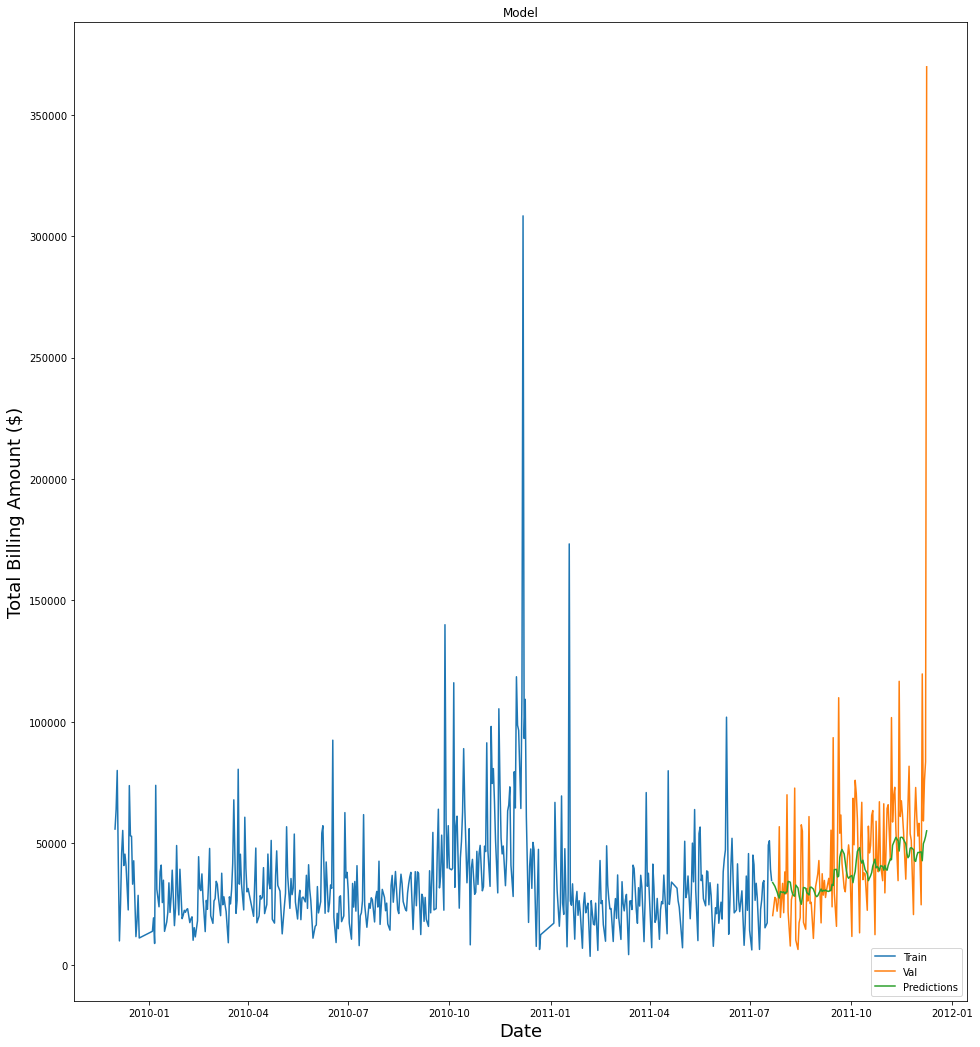

In [7]:
ts_data_rmse , ts_data_mape , pred_ts_data = run_univariate_LSTM(ts_data, 60, 0.8, False, 10)

# LSTM with with log returns data (first difference)

Epoch 1/10
421/421 [==============================] - 13s 22ms/step - loss: 0.0371
Epoch 2/10
421/421 [==============================] - 9s 22ms/step - loss: 0.0264
Epoch 3/10
421/421 [==============================] - 9s 22ms/step - loss: 0.0256
Epoch 4/10
421/421 [==============================] - 9s 22ms/step - loss: 0.0218
Epoch 5/10
421/421 [==============================] - 9s 22ms/step - loss: 0.0190
Epoch 6/10
421/421 [==============================] - 10s 23ms/step - loss: 0.0165
Epoch 7/10
421/421 [==============================] - 9s 22ms/step - loss: 0.0174
Epoch 8/10
421/421 [==============================] - 9s 22ms/step - loss: 0.0155
Epoch 9/10
421/421 [==============================] - 9s 22ms/step - loss: 0.0148
Epoch 10/10
421/421 [==============================] - 9s 21ms/step - loss: 0.0163
RMSE:  0.19612236796308619
MAPE:  271.96001414187344


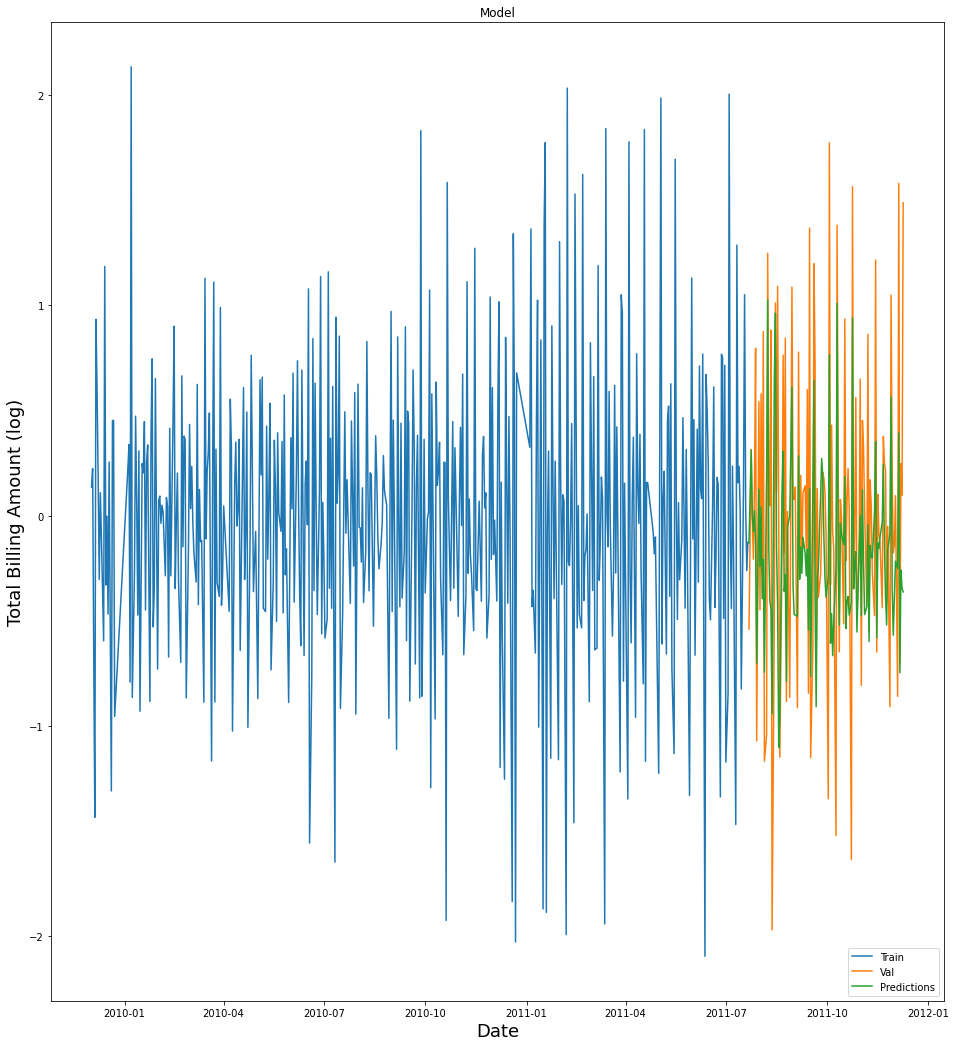

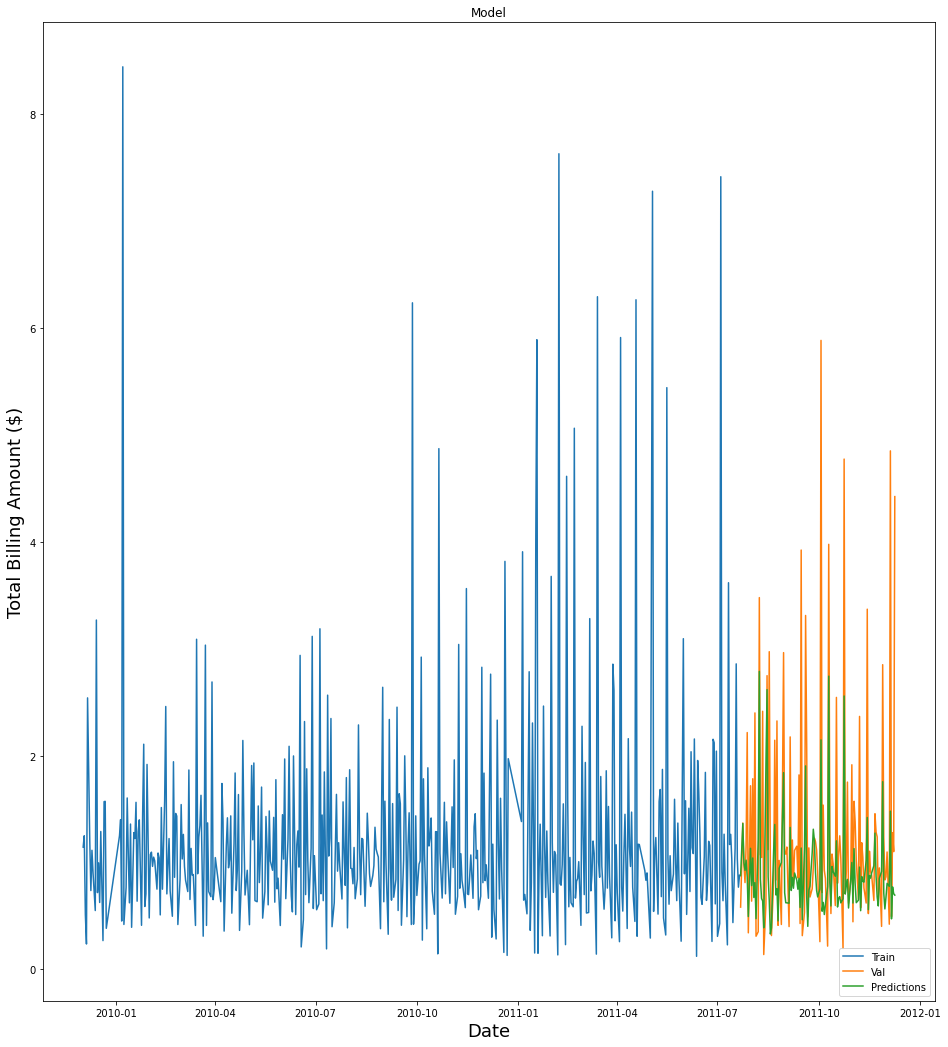

In [8]:
log_returns_rmse , log_returns_mape , pred_log_returns = run_univariate_LSTM(log_returns, 60, 0.8, True, 10)

# LSTM with log returns and differentiation of order 12

Epoch 1/10
412/412 [==============================] - 13s 22ms/step - loss: 0.0263
Epoch 2/10
412/412 [==============================] - 9s 22ms/step - loss: 0.0187
Epoch 3/10
412/412 [==============================] - 9s 22ms/step - loss: 0.0175
Epoch 4/10
412/412 [==============================] - 9s 22ms/step - loss: 0.0146
Epoch 5/10
412/412 [==============================] - 9s 23ms/step - loss: 0.0119
Epoch 6/10
412/412 [==============================] - 9s 23ms/step - loss: 0.0140
Epoch 7/10
412/412 [==============================] - 9s 23ms/step - loss: 0.0126
Epoch 8/10
412/412 [==============================] - 10s 24ms/step - loss: 0.0123
Epoch 9/10
412/412 [==============================] - 9s 23ms/step - loss: 0.0126
Epoch 10/10
412/412 [==============================] - 9s 22ms/step - loss: 0.0116
RMSE:  0.045846098852841445
MAPE:  221.12165812406226


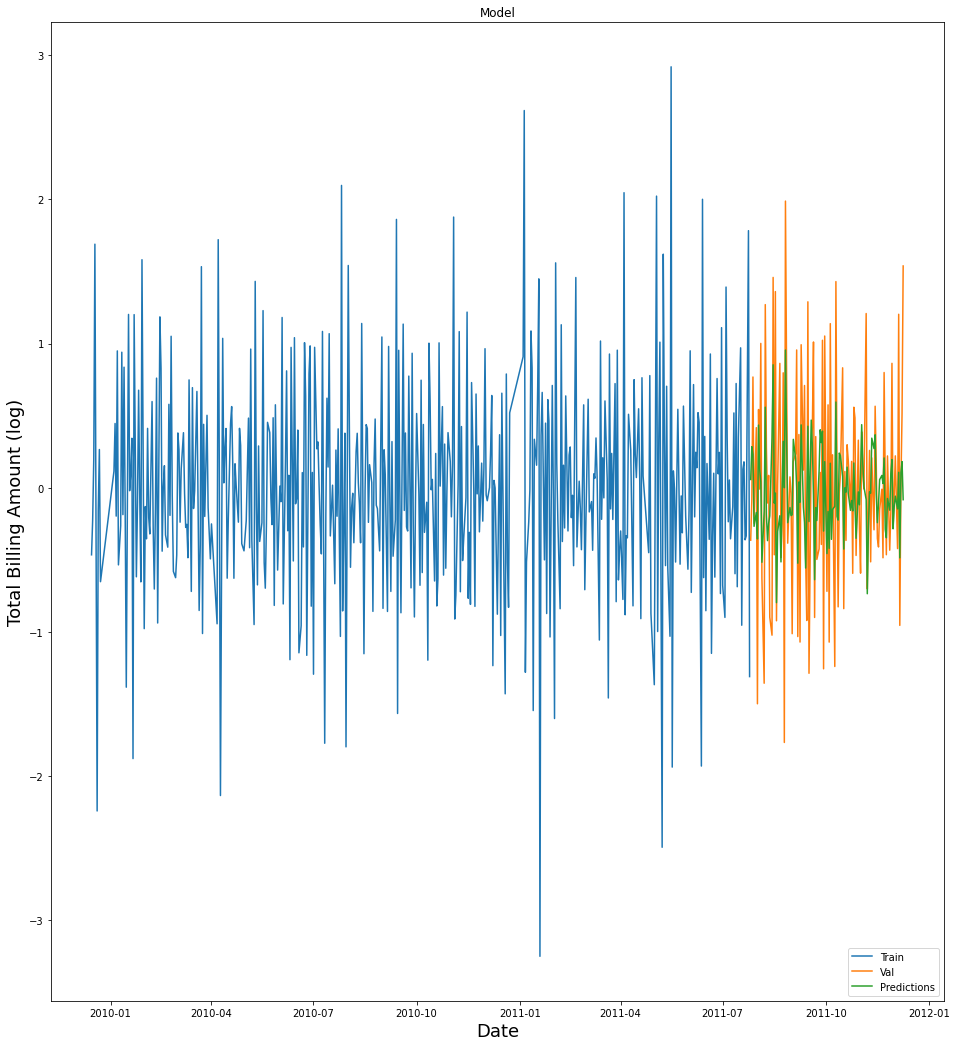

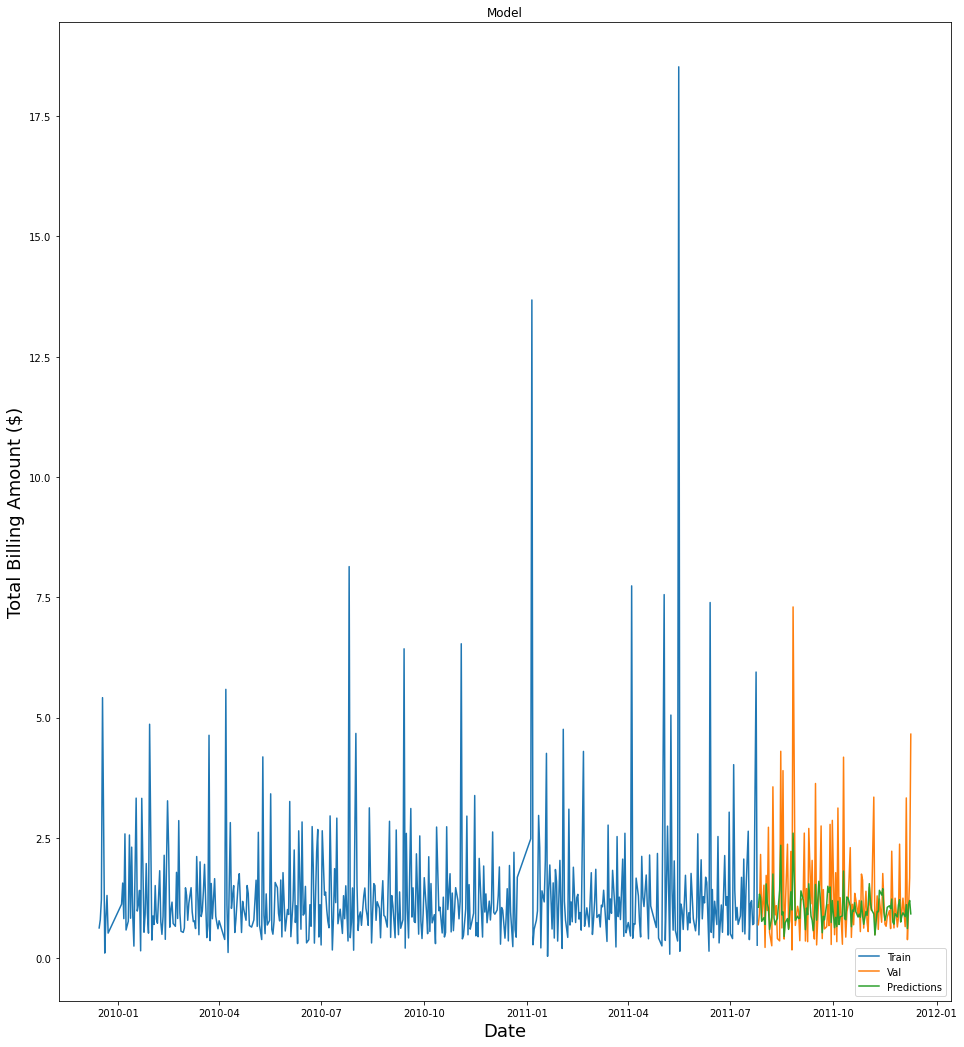

In [9]:
df_diff_rmse , df_diff_mape , pred_df_diff = run_univariate_LSTM(df_diff, 60, 0.8, True, 10)

# LSTM with Smoothing and moving average data 

Epoch 1/10
417/417 [==============================] - 13s 22ms/step - loss: 0.0222
Epoch 2/10
417/417 [==============================] - 9s 22ms/step - loss: 0.0075
Epoch 3/10
417/417 [==============================] - 9s 22ms/step - loss: 0.0041
Epoch 4/10
417/417 [==============================] - 9s 22ms/step - loss: 0.0042
Epoch 5/10
417/417 [==============================] - 9s 22ms/step - loss: 0.0031
Epoch 6/10
417/417 [==============================] - 9s 21ms/step - loss: 0.0035
Epoch 7/10
417/417 [==============================] - 9s 22ms/step - loss: 0.0037
Epoch 8/10
417/417 [==============================] - 9s 21ms/step - loss: 0.0034
Epoch 9/10
417/417 [==============================] - 9s 22ms/step - loss: 0.0036
Epoch 10/10
417/417 [==============================] - 10s 23ms/step - loss: 0.0034
RMSE:  0.0750753988870784
MAPE:  3.332627960286527


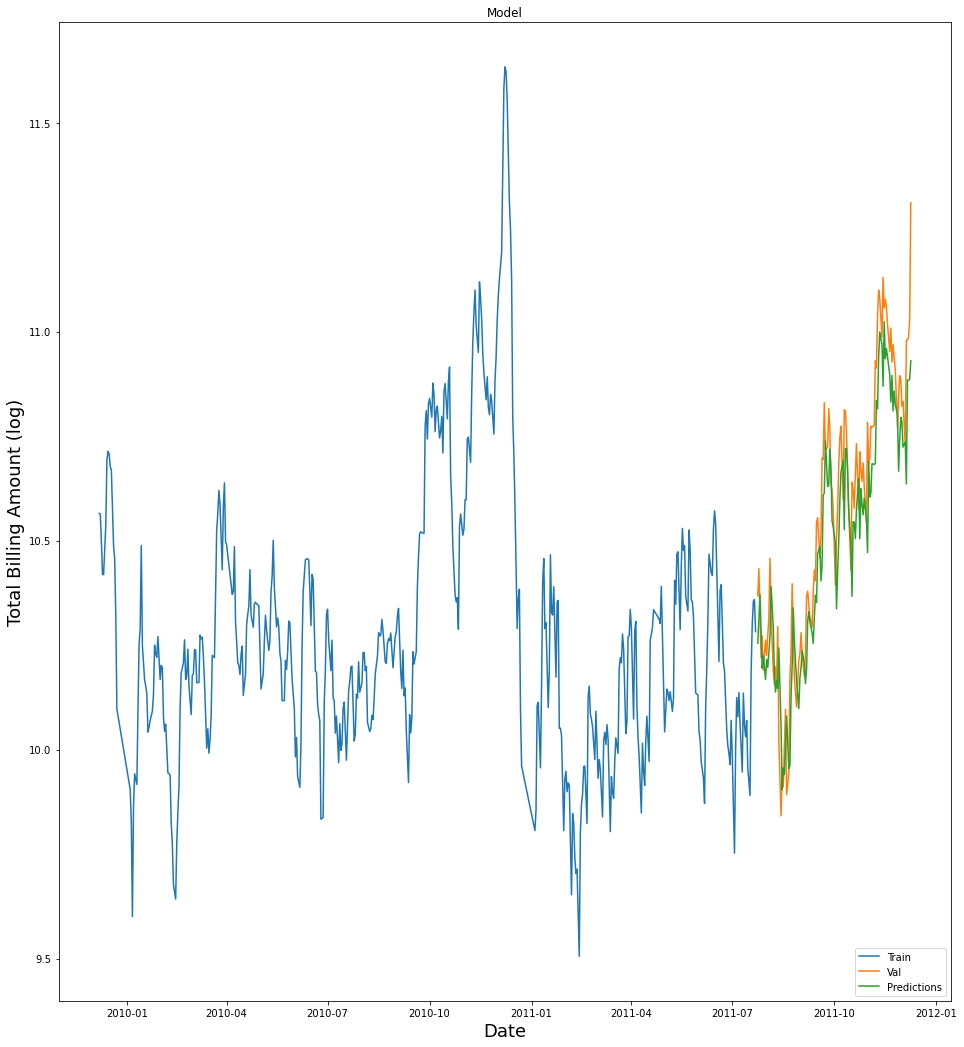

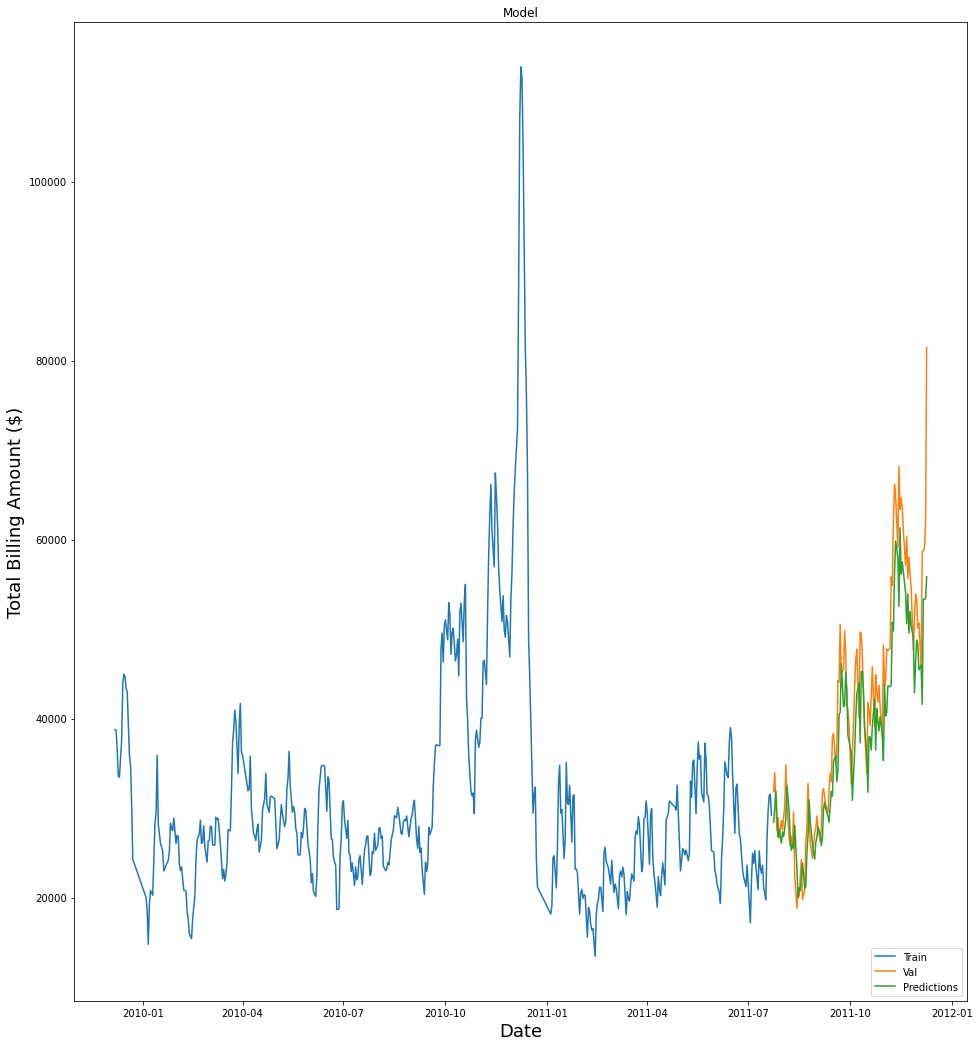

In [10]:
log_data_r_mean_rmse , log_data_r_mean_mape , pred_log_data_r_mean = run_univariate_LSTM(log_data_r_mean , 60, 0.8, True, 10)

# Comparison

In [11]:
#Compare MAPE

print("Original Data: ",ts_data_mape)
print("Log Returns (first difference) Data: ",log_returns_mape)
print("Log differences (order 12) Data: ",df_diff_mape)
print("Smoothing and Moving Average Data: ",log_data_r_mean_mape)

Original Data:  57.222876791320374
Log Returns (first difference) Data:  271.96001414187344
Log differences (order 12) Data:  221.12165812406226
Smoothing and Moving Average Data:  3.332627960286527


By the MAPE indicator, we can see that the smoothing data has got the best result